<b><font color="SteelBlue" size="+3">Segmentez des clients d'un site e-commerce</font></b>

# Introduction

Ce notebook la partie contrat de maintenance du projet pour OLIST.

## Imports

In [1]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

## Data

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'Brazil_Regions.png',
 'carte-bresil.jpg',
 'Carte_bresil.png',
 'data',
 'Deveau_Estelle_1_script_032024.sql',
 'Deveau_Estelle_2_notebook_exploration_032024.ipynb',
 'Deveau_Estelle_3_notebook_essais_032024.ipynb',
 'Deveau_Estelle_4_notebook_simulation_032024.ipynb',
 'svg']

In [3]:
os.listdir("data/sources/")

['Customer.csv',
 'CustomerCategoryCounts.csv',
 'CustomerPaymentPreferences.csv',
 'periodes',
 'Script-avec-periode.sql',
 'Script_projet.sql',
 'svg_scripts']

In [4]:
os.listdir("data/sources/periodes")

['Customer', 'Payment']

In [5]:
os.listdir("data/sources/periodes/Customer")

['Customer_170101_180101.csv',
 'Customer_170101_180115.csv',
 'Customer_170101_180201.csv',
 'Customer_170101_180215.csv',
 'Customer_170101_180301.csv',
 'Customer_170101_180315.csv',
 'Customer_170101_180401.csv',
 'Customer_170101_180415.csv',
 'Customer_170101_180501.csv',
 'Customer_170101_180515.csv',
 'Customer_170101_180601.csv',
 'Customer_170101_180615.csv',
 'Customer_170101_180701.csv',
 'Customer_170101_180715.csv',
 'Customer_170101_180801.csv']

In [6]:
os.listdir("data/sources/periodes/Payment")

['CustomerPaymentPreferences_170101_180101.csv',
 'CustomerPaymentPreferences_170101_180115.csv',
 'CustomerPaymentPreferences_170101_180201.csv',
 'CustomerPaymentPreferences_170101_180215.csv',
 'CustomerPaymentPreferences_170101_180301.csv',
 'CustomerPaymentPreferences_170101_180315.csv',
 'CustomerPaymentPreferences_170101_180401.csv',
 'CustomerPaymentPreferences_170101_180415.csv',
 'CustomerPaymentPreferences_170101_180501.csv',
 'CustomerPaymentPreferences_170101_180515.csv',
 'CustomerPaymentPreferences_170101_180601.csv',
 'CustomerPaymentPreferences_170101_180615.csv',
 'CustomerPaymentPreferences_170101_180701.csv',
 'CustomerPaymentPreferences_170101_180715.csv',
 'CustomerPaymentPreferences_170101_180801.csv']

# Liste des fichiers

In [7]:
pathCustomer = "./data/sources/periodes/Customer"
pathPayment = "./data/sources/periodes/Payment"

In [8]:
# Obtenir la liste des fichiers CSV dans chaque répertoire
data_customer = sorted([os.path.join(pathCustomer, f) for f in os.listdir(pathCustomer) if f.endswith('.csv')])
data_payment = sorted([os.path.join(pathPayment, f) for f in os.listdir(pathPayment) if f.endswith('.csv')])

In [9]:
assert len(data_customer) == len(data_payment), "Les répertoires doivent contenir le même nombre de fichiers CSV."

# Prétraitement des données

In [10]:
def merge(df_customer, df_payment):
    # Calculer la somme totale des paiements pour chaque client
    total_payment_by_customer = df_payment.groupby('customer_unique_id')['TotalPaymentValue'].sum()

    # Calculer la somme totale des échéances de paiement pour chaque client
    total_installments_by_customer = df_payment.groupby('customer_unique_id')['TotalInstallments'].sum()

    # Créer un DataFrame pour la somme totale des paiements et des échéances de paiement
    total_by_customer = pd.concat([total_payment_by_customer, total_installments_by_customer], axis=1).reset_index()

    # Pivot pour obtenir le pourcentage par type de paiement pour chaque client
    df_payment_pivot = df_payment.pivot_table(index='customer_unique_id', 
                                              columns='payment_type', 
                                              values='TotalPaymentValue', 
                                              aggfunc='sum',
                                              fill_value=0)

    # Calculer les pourcentages de paiement pour chaque type
    for col in df_payment_pivot.columns:
        col_pct_name = f'{col}_pct'
        df_payment_pivot[col_pct_name] = df_payment_pivot[col] / total_by_customer.set_index('customer_unique_id')['TotalPaymentValue'] * 100

    # Ajouter les données totales au DataFrame pivoté
    df_payment_pivot = df_payment_pivot.merge(total_by_customer, on='customer_unique_id')

    # Fusionner df_customer avec les colonnes sélectionnées de df_payment_pivot
    df_merged = pd.merge(df_customer,
                         df_payment_pivot[['customer_unique_id','boleto_pct','credit_card_pct','debit_card_pct','voucher_pct',
                                       'TotalPaymentValue','TotalInstallments']],
                         on='customer_unique_id',
                         how='left')

    return df_merged

In [11]:
def nettoyage(data):
    # Formats
    data['FirstOrderDate'] = pd.to_datetime(data['FirstOrderDate'])
    data['LastOrderDate'] = pd.to_datetime(data['LastOrderDate'])

    # doublons
    data = data.drop_duplicates(subset=["customer_unique_id"])
    data = data.drop_duplicates(subset=['FirstOrderDate','TotalSpent','customer_city'])

    #print(f'Taille du dataframe après le nettoyage : {data.shape}')

    return data


In [12]:
def verification(data):
    tolerance = 0.1
    data = data.copy()

    # Vérifier que la somme des pourcentages des sommes dépensées dans chaque catégorie est proche de 100%
    data = data[(abs(data['boleto_pct'] + data['credit_card_pct'] + data['debit_card_pct'] + data['voucher_pct'] - 100) <= tolerance)]
      
    # Vérifier la cohérence entre la valeur totale des paiements et la somme de TotalSpent + TotalFreight
    data['payment_difference'] = abs(data['TotalPaymentValue'] - (data['TotalSpent'] + data['TotalFreight']))
    data = data[data['payment_difference'] <= data['TotalPaymentValue'] * tolerance]
    
    # Supprimer les lignes où 'AverageReviewScore' n'est pas compris entre 0 et 5
    data = data.query("AverageReviewScore.isna() or (AverageReviewScore >= 0 and AverageReviewScore <= 5)")
    
    # Supprimer les lignes où 'NumberOfComments' ou 'NumberOfCommentTitles' est supérieur à 'NumberOfReviews'
    data = data.query("NumberOfComments <= NumberOfReviews and NumberOfCommentTitles <= NumberOfReviews")
    
    # Remplacer les valeurs de 'DifferentCategories' égales à 0 par 1
    data.loc[data['DifferentCategories'] == 0, 'DifferentCategories'] = 1

    # Suppression des colonnes qui ne servaient qu'à la verification des données
    data = data.drop(columns=['TotalPaymentValue'])

    #print(f'Taille du dataframe après la vérification : {data.shape}')

    return data

In [13]:
def completion(data):
    # Supprimer les lignes où la colonne 'AvgWeight' est NaN
    data = data.dropna(subset=['AvgWeight'])
    #data['AvgWeight'] = data['AvgWeight'].fillna(0)

    #print(f'Taille du dataframe après la complétion : {data.shape}')

    return data

In [14]:
def features(df, featureslist):
    #print(df.columns.tolist())
    df = df.copy()
    
    # Recence
    reference_date = df['LastOrderDate'].max()
    df['Recency'] = (reference_date - df['LastOrderDate']).dt.days

    # Frequence
    df['Frequency'] = df['TotalOrders']

    # Montant (= panier moyen)
    df['TotalAmount'] = df['TotalSpent'] + df['TotalFreight']
    df['AvgBasket'] = df['TotalAmount']/df['TotalOrders']

    # Calcul de l'indice d'engagement en fonction des commentaires
    df['EngagementIndex'] = (0.5 * df['NumberOfReviews'] + 0.25 * df['NumberOfCommentTitles'] + 0.25 * df['NumberOfComments']
                            ) / (df['nb_item'])

    df = df[['customer_unique_id'] + featureslist]
    
    #print(f'Taille du dataframe après le feature engineering : {df.shape}')

    return df

In [15]:
standard_scaler = StandardScaler()

def scale(data):
    # Définir 'customer_unique_id' comme l'index du DataFrame
    data = data.set_index('customer_unique_id')
    
    scaled_data = pd.DataFrame(standard_scaler.fit_transform(data), index=data.index, columns=data.columns)
    
    return scaled_data

In [16]:
def traitement(file_cutomer, file_payment, featureslist):
    df_merged = merge(file_cutomer, file_payment)
    df_cleaned = nettoyage(df_merged)
    df_verified = verification(df_cleaned)
    df_completed = completion(df_verified)
    df_featured = features(df_completed, featureslist)
    df_scaled = scale(df_featured)
    
    #print(f'Taille du dataframe après le traitement des données : {df_featured.shape}')

    return df_scaled

# ARI

## Sans reentrainement

In [86]:
# Calcul ARI
def ari_calc_retrain(customer_files, payment_files, retrain_period):

    # On commence à 1.0 pour la première période
    ari_scores = []


    # liste des features
    features = [ 'Recency', 'Frequency', 'AvgBasket', 'nb_item', 'AverageReviewScore', 'EngagementIndex', 'ActualDeliveryTime', 
               'EstimatedActualDifference', 'AvgWeight', 'TotalInstallments', 'boleto_pct', 'voucher_pct']
    
    # Initialiser KMeans une seule fois avec le nombre de clusters déterminé
    kmeans = KMeans(n_clusters=9, random_state=42,n_init=10)
    customer_labels_first_period = {} 

    # Condition initiale pour le ré-entraînement
    should_retrain = True if retrain_period != -1 else False
    
    for i, (file_customer, file_payment) in enumerate(zip(customer_files, payment_files)):
        # Charger les fichiers CSV
        df_customer = pd.read_csv(file_customer)
        df_payment = pd.read_csv(file_payment)
        
        # Prétraitement
        data = traitement(df_customer, df_payment, features)  
        #data.set_index('customer_unique_id', inplace=True)  

        if i == 0 or (should_retrain and i % retrain_period == 0):
            # Entraîner KMeans sur la première période
            kmeans.fit(data[features])
            # identifiant des client p1
            customer_ids_first_period = set(data.index)  
            # Stockage des labels de la première période
            customer_labels_first_period = {idx: lbl for idx, lbl in zip(data.index, kmeans.labels_)}
            ari_scores.append(1.0)
        else:
            # Filtrer pour ne garder que les clients présents lors de la première période
            data_common = data.loc[data.index.isin(customer_ids_first_period)].copy()
            # prediction si reentrainement
            predicted_clusters = kmeans.predict(data_common[features])
            # Filtrer labels_de_reference pour ne garder que ceux correspondant aux clients communs
            labels_de_reference = [customer_labels_first_period[idx] for idx in data_common.index if idx in customer_labels_first_period]
            # Calcul de l'ARI
            ari = adjusted_rand_score(labels_de_reference, predicted_clusters)
            ari_scores.append(ari)
    
    return ari_scores


In [87]:
ari_scores = ari_calc_retrain(data_customer, data_payment, -1)
ari_scores

[1.0,
 0.9436108655680427,
 0.8770572623185264,
 0.8332862056194202,
 0.7808504691054889,
 0.734386750079927,
 0.6880605586465735,
 0.6563938701946584,
 0.6270099642173933,
 0.5995686630358056,
 0.5806689319435129,
 0.566706925733659,
 0.5540956749283781,
 0.545966732953086,
 0.534522581417026]

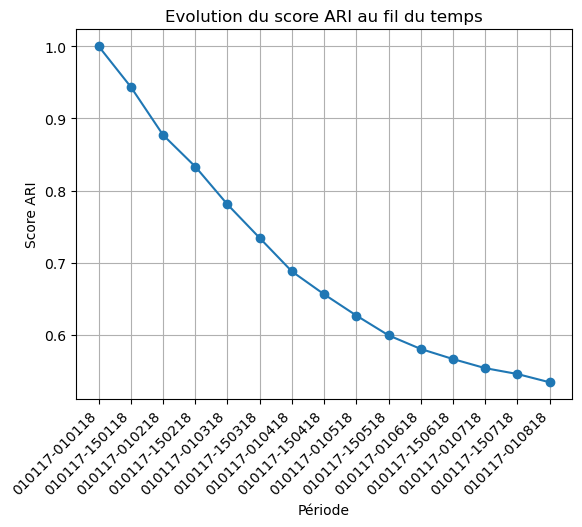

In [88]:
# Affichage de la courbe ARI
plt.plot(ari_scores, marker='o', linestyle='-')
plt.title('Evolution du score ARI au fil du temps')
plt.xlabel('Période')
plt.ylabel('Score ARI')
plt.xticks(range(len(ari_scores)), ['010117-010118', '010117-150118', '010117-010218', '010117-150218',
                                    '010117-010318', '010117-150318', '010117-010418', '010117-150418',
                                    '010117-010518', '010117-150518', '010117-010618', '010117-150618',
                                    '010117-010718', '010117-150718', '010117-010818'], rotation=45, ha='right') 
plt.grid(True)
plt.show()

## Réentrainement tous les 2 mois

In [89]:
ari_scores = ari_calc_retrain(data_customer, data_payment, 4)

In [90]:
ari_scores

[1.0,
 0.9436108655680427,
 0.8770572623185264,
 0.8332862056194202,
 1.0,
 0.9605859664245961,
 0.9064751674719471,
 0.8715836312726185,
 1.0,
 0.9659894708310099,
 0.9389833909405136,
 0.9142548400446807,
 1.0,
 0.980747007677049,
 0.946213093111236]

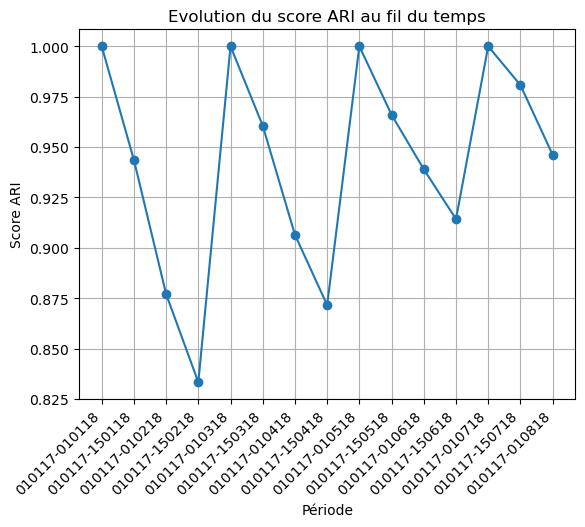

In [91]:
# Affichage de la courbe ARI
plt.plot(ari_scores, marker='o', linestyle='-')
plt.title('Evolution du score ARI au fil du temps')
plt.xlabel('Période')
plt.ylabel('Score ARI')
plt.xticks(range(len(ari_scores)), ['010117-010118', '010117-150118', '010117-010218', '010117-150218',
                                    '010117-010318', '010117-150318', '010117-010418', '010117-150418',
                                    '010117-010518', '010117-150518', '010117-010618', '010117-150618',
                                    '010117-010718', '010117-150718', '010117-010818'], rotation=45, ha='right') 
plt.grid(True)
plt.show()